In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

import process_data
import network
import config

In [2]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

normalized_scan_val_set_full = np.load('normalized_scan_100610_full.npy')

In [3]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3
bvals_all_val_set = np.loadtxt(config.data_folder2 + '/100610/bvals') * 1e-3

In [4]:
big_b_indices_100206 = np.where(bvals_all_100206 != 0.005)[0]
big_b_indices_val_set = np.where(bvals_all_val_set != 0.005)[0]

In [5]:
bvals_100206 = bvals_all_100206[big_b_indices_100206]
bvals_val_set = bvals_all_100206[big_b_indices_val_set]

In [6]:
normalized_scan_100206_no_b5 = normalized_scan_100206_full[:, big_b_indices_100206]
normalized_scan_val_set_no_b5 = normalized_scan_val_set_full[:, big_b_indices_val_set]

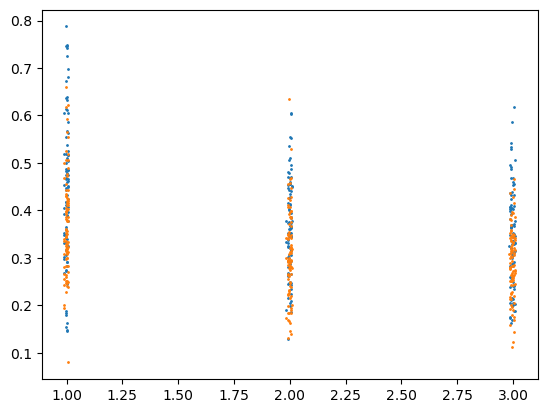

In [7]:
plt.plot(bvals_100206, normalized_scan_100206_no_b5[42,:], "o", markersize = 1)
plt.plot(bvals_val_set, normalized_scan_val_set_no_b5[42,:], "o", markersize = 1)

In [8]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

n_val_set_all = np.loadtxt(config.data_folder2 + '/100610/bvecs')

In [9]:
n_100206 = n_100206_all[:,big_b_indices_100206].T
print(n_100206.shape)

b_values_100206 = torch.FloatTensor(bvals_100206)
gradient_directions_100206 = torch.FloatTensor(n_100206)

n_val_set = n_val_set_all[:,big_b_indices_val_set].T
print(n_val_set.shape)

b_values_val_set = torch.FloatTensor(bvals_val_set)
gradient_directions_val_set = torch.FloatTensor(n_val_set)

(270, 3)
(270, 3)


In [10]:
batch_size = 128
num_batches = len(normalized_scan_100206_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [11]:
val_set = torch.from_numpy(normalized_scan_val_set_no_b5.astype(np.float32))
print(val_set.shape)
print(type(val_set))

torch.Size([880154, 270])
<class 'torch.Tensor'>


In [30]:
# net_golden_std = network.BallStickNet(gradient_directions_100206, b_values_100206)
# net_golden_std.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_norm_01_Feb_182e.pt"))
# criterion = nn.MSELoss()
# optimizer = optim.Adam(net_golden_std.parameters(), lr = 0.00001)

net = network.BallStickNet(gradient_directions_100206, b_values_100206)

# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [31]:
train_loss_list=[]
avg_train_loss_list=[]

val_loss_list = []
avg_val_loss_list=[]


# Best loss
best_train_loss = 1e16
best_val_loss = 1e16
num_bad_epochs_train = 0
num_bad_epochs_val = 0
patience = 20

for epoch in range(1000):
    print("Epoch: {}; Bad training epochs: {}; Bad validation epochs: {}".format(epoch, num_bad_epochs_train, num_bad_epochs_val))
    current_learning_rate = optimizer.param_groups[0]['lr']
    if current_learning_rate != 0.00001:
        print("Current learning rate: {}".format(current_learning_rate))
    print("-----------------------------------------------------------------")
    
    net.train()
    running_train_loss = 0.
    
#     Training
    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        # if i == 1:
        #     print("Prediction:")
        #     print(X_pred)
        #     print("Real:")
        #     print(X_batch)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    train_loss_list.append(running_train_loss)
    avg_train_loss_list.append(running_train_loss/num_batches)
    print("Loss: {}; Average Loss: {}".format(running_train_loss, running_train_loss/num_batches))
    
#     Validation
    temp_model = net.state_dict()
    val_net = network.BallStickNet(gradient_directions_val_set, b_values_val_set)
    val_net.load_state_dict(temp_model)
    val_net.eval()
    with torch.no_grad():
        val_pred, _, _, _, _, _, _, _ = val_net(val_set)
        # print("Val Prediction:")
        # print(val_pred)
        # print("Val Real:")
        # print(val_set)
        val_loss = criterion(val_pred.type(torch.FloatTensor), val_set.type(torch.FloatTensor))
        running_val_loss = val_loss.item()
        val_loss_list.append(running_val_loss)
        print("Validation Loss: {}".format(running_val_loss))
        
    scheduler.step(running_val_loss)
    
    if running_train_loss < best_train_loss:
        best_train_loss = running_train_loss
        num_bad_epochs_train = 0
        
    elif running_train_loss >= best_train_loss:
        num_bad_epochs_train = num_bad_epochs_train + 1

    if running_val_loss < best_val_loss:
        print("############### Saving good model for validation set ###############################")
        final_model_valset = net.state_dict()
        best_val_loss = running_val_loss
        num_bad_epochs_val = 0
    elif running_val_loss >= best_val_loss:
        num_bad_epochs_val += 1
        if num_bad_epochs_val == patience:
            print("Done, best training loss per epoch: {}; best validation loss: {}".format(best_train_loss, best_val_loss))
            break

print("Done") 
net.load_state_dict(final_model_valset)

Epoch: 0; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.17it/s]


Loss: 3916.569272518158; Average Loss: 0.535929019227991
Validation Loss: 0.5323975682258606
############### Saving good model for validation set ###############################
Epoch: 1; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 105.94it/s]


Loss: 3915.995497405529; Average Loss: 0.5358505059394539
Validation Loss: 0.5323231220245361
############### Saving good model for validation set ###############################
Epoch: 2; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.44it/s]


Loss: 3915.6634523272514; Average Loss: 0.5358050701049879
Validation Loss: 0.5322695970535278
############### Saving good model for validation set ###############################
Epoch: 3; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 123.91it/s]


Loss: 3915.4717886447906; Average Loss: 0.5357788435474535
Validation Loss: 0.5322517156600952
############### Saving good model for validation set ###############################
Epoch: 4; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.70it/s]


Loss: 1372.2632894292474; Average Loss: 0.1877754911643743
Validation Loss: 0.060609400272369385
############### Saving good model for validation set ###############################
Epoch: 5; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.71it/s]


Loss: 425.97604790329933; Average Loss: 0.05828900491287621
Validation Loss: 0.058156948536634445
############### Saving good model for validation set ###############################
Epoch: 6; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.08it/s]


Loss: 412.9203157015145; Average Loss: 0.05650250625362815
Validation Loss: 0.057287365198135376
############### Saving good model for validation set ###############################
Epoch: 7; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.86it/s]


Loss: 407.51199274137616; Average Loss: 0.055762451114036146
Validation Loss: 0.05672473832964897
############### Saving good model for validation set ###############################
Epoch: 8; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.52it/s]


Loss: 402.9839248433709; Average Loss: 0.05514284685869881
Validation Loss: 0.05610893294215202
############### Saving good model for validation set ###############################
Epoch: 9; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.76it/s]


Loss: 396.3098173439503; Average Loss: 0.05422958639079779
Validation Loss: 0.055313874036073685
############### Saving good model for validation set ###############################
Epoch: 10; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.46it/s]


Loss: 391.2682970762253; Average Loss: 0.05353972319050702
Validation Loss: 0.0549086257815361
############### Saving good model for validation set ###############################
Epoch: 11; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.80it/s]


Loss: 388.1090668477118; Average Loss: 0.053107425677026796
Validation Loss: 0.05461139231920242
############### Saving good model for validation set ###############################
Epoch: 12; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.30it/s]


Loss: 385.58743750303984; Average Loss: 0.05276237513725231
Validation Loss: 0.05439325049519539
############### Saving good model for validation set ###############################
Epoch: 13; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.01it/s]


Loss: 383.29487117007375; Average Loss: 0.05244866874248409
Validation Loss: 0.054160017520189285
############### Saving good model for validation set ###############################
Epoch: 14; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.42it/s]


Loss: 380.988534078002; Average Loss: 0.052133078007389436
Validation Loss: 0.05391690880060196
############### Saving good model for validation set ###############################
Epoch: 15; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.47it/s]


Loss: 378.51320772990584; Average Loss: 0.05179436340037026
Validation Loss: 0.05368046090006828
############### Saving good model for validation set ###############################
Epoch: 16; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.78it/s]


Loss: 375.904793407768; Average Loss: 0.0514374375215884
Validation Loss: 0.05344552919268608
############### Saving good model for validation set ###############################
Epoch: 17; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.13it/s]


Loss: 373.31282633915544; Average Loss: 0.051082762224843384
Validation Loss: 0.05310561880469322
############### Saving good model for validation set ###############################
Epoch: 18; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:13<00:00, 99.10it/s]


Loss: 370.98252471908927; Average Loss: 0.050763892271358683
Validation Loss: 0.05287117511034012
############### Saving good model for validation set ###############################
Epoch: 19; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.35it/s]


Loss: 368.94488379731774; Average Loss: 0.05048506893778294
Validation Loss: 0.052627623081207275
############### Saving good model for validation set ###############################
Epoch: 20; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 130.05it/s]


Loss: 367.1737615838647; Average Loss: 0.050242715049789916
Validation Loss: 0.05246288329362869
############### Saving good model for validation set ###############################
Epoch: 21; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.14it/s]


Loss: 365.63999742269516; Average Loss: 0.05003284036982692
Validation Loss: 0.052289679646492004
############### Saving good model for validation set ###############################
Epoch: 22; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.41it/s]


Loss: 364.2483614049852; Average Loss: 0.049842413985356486
Validation Loss: 0.05219694972038269
############### Saving good model for validation set ###############################
Epoch: 23; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.24it/s]


Loss: 362.99093785881996; Average Loss: 0.04967035274477558
Validation Loss: 0.051999542862176895
############### Saving good model for validation set ###############################
Epoch: 24; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.04it/s]


Loss: 361.8060002401471; Average Loss: 0.049508210213484824
Validation Loss: 0.05194489285349846
############### Saving good model for validation set ###############################
Epoch: 25; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.26it/s]


Loss: 360.7166292183101; Average Loss: 0.04935914466588808
Validation Loss: 0.051757268607616425
############### Saving good model for validation set ###############################
Epoch: 26; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.84it/s]


Loss: 359.71027883142233; Average Loss: 0.04922143935843217
Validation Loss: 0.051654111593961716
############### Saving good model for validation set ###############################
Epoch: 27; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:17<00:00, 94.45it/s]


Loss: 358.81971649825573; Average Loss: 0.04909957806489542
Validation Loss: 0.05156610533595085
############### Saving good model for validation set ###############################
Epoch: 28; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.86it/s]


Loss: 357.9972799234092; Average Loss: 0.04898703885104122
Validation Loss: 0.05151525139808655
############### Saving good model for validation set ###############################
Epoch: 29; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:19<00:00, 91.77it/s]


Loss: 357.27764105796814; Average Loss: 0.04888856609988617
Validation Loss: 0.05141584202647209
############### Saving good model for validation set ###############################
Epoch: 30; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.03it/s]


Loss: 356.6212344802916; Average Loss: 0.04879874582379469
Validation Loss: 0.051393166184425354
############### Saving good model for validation set ###############################
Epoch: 31; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.41it/s]


Loss: 356.04610259085894; Average Loss: 0.048720046878880534
Validation Loss: 0.05127152428030968
############### Saving good model for validation set ###############################
Epoch: 32; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.59it/s]


Loss: 355.5311720445752; Average Loss: 0.04864958566565069
Validation Loss: 0.05122032389044762
############### Saving good model for validation set ###############################
Epoch: 33; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 110.82it/s]


Loss: 355.0429514981806; Average Loss: 0.04858277935114678
Validation Loss: 0.051184047013521194
############### Saving good model for validation set ###############################
Epoch: 34; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.88it/s]


Loss: 354.61923161521554; Average Loss: 0.048524799071594904
Validation Loss: 0.05111456289887428
############### Saving good model for validation set ###############################
Epoch: 35; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.30it/s]


Loss: 354.2056671977043; Average Loss: 0.04846820842880464
Validation Loss: 0.051103733479976654
############### Saving good model for validation set ###############################
Epoch: 36; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.14it/s]


Loss: 353.8361385129392; Average Loss: 0.04841764347467696
Validation Loss: 0.051059406250715256
############### Saving good model for validation set ###############################
Epoch: 37; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.22it/s]


Loss: 353.50253641977906; Average Loss: 0.048371994583987284
Validation Loss: 0.051018595695495605
############### Saving good model for validation set ###############################
Epoch: 38; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.76it/s]


Loss: 353.1670402251184; Average Loss: 0.048326086511373614
Validation Loss: 0.05096324905753136
############### Saving good model for validation set ###############################
Epoch: 39; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.07it/s]


Loss: 352.8680823519826; Average Loss: 0.048285178209083554
Validation Loss: 0.0509054996073246
############### Saving good model for validation set ###############################
Epoch: 40; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.94it/s]


Loss: 352.5668730996549; Average Loss: 0.04824396183629651
Validation Loss: 0.05092790350317955
Epoch: 41; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.18it/s]


Loss: 352.2945928797126; Average Loss: 0.048206704006528815
Validation Loss: 0.05083286017179489
############### Saving good model for validation set ###############################
Epoch: 42; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.76it/s]


Loss: 352.0290903188288; Average Loss: 0.048170373606845764
Validation Loss: 0.05081835761666298
############### Saving good model for validation set ###############################
Epoch: 43; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 114.38it/s]


Loss: 351.78124183788896; Average Loss: 0.0481364589269142
Validation Loss: 0.05080390349030495
############### Saving good model for validation set ###############################
Epoch: 44; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 112.35it/s]


Loss: 351.5297548882663; Average Loss: 0.0481020463722313
Validation Loss: 0.050762638449668884
############### Saving good model for validation set ###############################
Epoch: 45; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.89it/s]


Loss: 351.31088519468904; Average Loss: 0.04807209704360824
Validation Loss: 0.05074118822813034
############### Saving good model for validation set ###############################
Epoch: 46; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.71it/s]


Loss: 351.0532841272652; Average Loss: 0.04803684785540028
Validation Loss: 0.050751715898513794
Epoch: 47; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.09it/s]


Loss: 350.81698967143893; Average Loss: 0.048004514186020655
Validation Loss: 0.05071968212723732
############### Saving good model for validation set ###############################
Epoch: 48; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.68it/s]


Loss: 350.5921370945871; Average Loss: 0.04797374618152533
Validation Loss: 0.05067077651619911
############### Saving good model for validation set ###############################
Epoch: 49; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.47it/s]


Loss: 350.3848400451243; Average Loss: 0.04794538041121022
Validation Loss: 0.05064330995082855
############### Saving good model for validation set ###############################
Epoch: 50; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.50it/s]


Loss: 350.18881421908736; Average Loss: 0.04791855695389811
Validation Loss: 0.05061647668480873
############### Saving good model for validation set ###############################
Epoch: 51; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 114.61it/s]


Loss: 350.018767490983; Average Loss: 0.04789528838136056
Validation Loss: 0.05061603710055351
############### Saving good model for validation set ###############################
Epoch: 52; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.17it/s]


Loss: 349.84538432210684; Average Loss: 0.04787156326246673
Validation Loss: 0.050591375678777695
############### Saving good model for validation set ###############################
Epoch: 53; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.48it/s]


Loss: 349.6822695545852; Average Loss: 0.04784924323407023
Validation Loss: 0.050552066415548325
############### Saving good model for validation set ###############################
Epoch: 54; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:21<00:00, 89.66it/s]


Loss: 349.5292122922838; Average Loss: 0.04782829943791513
Validation Loss: 0.05056467652320862
Epoch: 55; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 102.34it/s]


Loss: 349.39196333289146; Average Loss: 0.047809518792130745
Validation Loss: 0.05055070295929909
############### Saving good model for validation set ###############################
Epoch: 56; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 105.04it/s]


Loss: 349.2478927820921; Average Loss: 0.047789804704719774
Validation Loss: 0.05047747865319252
############### Saving good model for validation set ###############################
Epoch: 57; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 102.29it/s]


Loss: 349.0964581593871; Average Loss: 0.04776908294463425
Validation Loss: 0.05054382607340813
Epoch: 58; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.38it/s]


Loss: 348.95519384741783; Average Loss: 0.04774975285268443
Validation Loss: 0.05047830939292908
Epoch: 59; Bad training epochs: 0; Bad validation epochs: 2
-----------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:28<00:00, 82.40it/s]


Loss: 348.8304162211716; Average Loss: 0.04773267873852923
Validation Loss: 0.050441332161426544
############### Saving good model for validation set ###############################
Epoch: 60; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:26<00:00, 84.90it/s]


Loss: 348.7019939683378; Average Loss: 0.047715105906997506
Validation Loss: 0.05047711730003357
Epoch: 61; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:23<00:00, 87.95it/s]


Loss: 348.5971570536494; Average Loss: 0.04770076040690332
Validation Loss: 0.05043570324778557
############### Saving good model for validation set ###############################
Epoch: 62; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 101.72it/s]


Loss: 348.47443253546953; Average Loss: 0.047683967232549196
Validation Loss: 0.05040568858385086
############### Saving good model for validation set ###############################
Epoch: 63; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:38<00:00, 74.17it/s]


Loss: 348.368660479784; Average Loss: 0.04766949377118008
Validation Loss: 0.050499774515628815
Epoch: 64; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.00it/s]


Loss: 348.26562666520476; Average Loss: 0.0476553950007122
Validation Loss: 0.050371378660202026
############### Saving good model for validation set ###############################
Epoch: 65; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.63it/s]


Loss: 348.1575873680413; Average Loss: 0.04764061129830888
Validation Loss: 0.05036606267094612
############### Saving good model for validation set ###############################
Epoch: 66; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.85it/s]


Loss: 348.0649359188974; Average Loss: 0.047627933212766475
Validation Loss: 0.05033081769943237
############### Saving good model for validation set ###############################
Epoch: 67; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 105.49it/s]


Loss: 347.9601287469268; Average Loss: 0.04761359178255703
Validation Loss: 0.050369661301374435
Epoch: 68; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 114.06it/s]


Loss: 347.8621986396611; Average Loss: 0.04760019138473742
Validation Loss: 0.0503435879945755
Epoch: 69; Bad training epochs: 0; Bad validation epochs: 2
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 112.05it/s]


Loss: 347.76673283055425; Average Loss: 0.04758712819246774
Validation Loss: 0.05034001171588898
Epoch: 70; Bad training epochs: 0; Bad validation epochs: 3
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.22it/s]


Loss: 347.6906655244529; Average Loss: 0.04757671942042323
Validation Loss: 0.050303347408771515
############### Saving good model for validation set ###############################
Epoch: 71; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.23it/s]


Loss: 347.59749227389693; Average Loss: 0.047563969933483434
Validation Loss: 0.05033072829246521
Epoch: 72; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.09it/s]


Loss: 347.5137058980763; Average Loss: 0.04755250491216151
Validation Loss: 0.05032139644026756
Epoch: 73; Bad training epochs: 0; Bad validation epochs: 2
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.50it/s]


Loss: 347.43161557242274; Average Loss: 0.04754127197214323
Validation Loss: 0.05032920464873314
Epoch: 74; Bad training epochs: 0; Bad validation epochs: 3
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.77it/s]


Loss: 347.34327214583755; Average Loss: 0.04752918338065648
Validation Loss: 0.050299566239118576
############### Saving good model for validation set ###############################
Epoch: 75; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.78it/s]


Loss: 347.26189374923706; Average Loss: 0.047518047858406826
Validation Loss: 0.05029681697487831
############### Saving good model for validation set ###############################
Epoch: 76; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.48it/s]


Loss: 347.1823847293854; Average Loss: 0.04750716813483653
Validation Loss: 0.050289224833250046
############### Saving good model for validation set ###############################
Epoch: 77; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.82it/s]


Loss: 347.111805010587; Average Loss: 0.04749751026417446
Validation Loss: 0.05029260367155075
Epoch: 78; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.75it/s]


Loss: 347.03712940216064; Average Loss: 0.04748729192695138
Validation Loss: 0.050286389887332916
############### Saving good model for validation set ###############################
Epoch: 79; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:18<00:00, 93.22it/s]


Loss: 346.9685095027089; Average Loss: 0.04747790223080308
Validation Loss: 0.05022256448864937
############### Saving good model for validation set ###############################
Epoch: 80; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.39it/s]


Loss: 346.89375641569495; Average Loss: 0.047467673291693345
Validation Loss: 0.05027507245540619
Epoch: 81; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.34it/s]


Loss: 346.8200842216611; Average Loss: 0.04745759225802697
Validation Loss: 0.05022229626774788
############### Saving good model for validation set ###############################
Epoch: 82; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.10it/s]


Loss: 346.74081974104047; Average Loss: 0.047446745996310956
Validation Loss: 0.05022348091006279
Epoch: 83; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.42it/s]


Loss: 346.68589029088616; Average Loss: 0.04743922965118858
Validation Loss: 0.05021693930029869
############### Saving good model for validation set ###############################
Epoch: 84; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.61it/s]


Loss: 346.6250820234418; Average Loss: 0.047430908870202765
Validation Loss: 0.050191693007946014
############### Saving good model for validation set ###############################
Epoch: 85; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.30it/s]


Loss: 346.5624859444797; Average Loss: 0.047422343451625576
Validation Loss: 0.05018287152051926
############### Saving good model for validation set ###############################
Epoch: 86; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.83it/s]


Loss: 346.4945256859064; Average Loss: 0.04741304401832326
Validation Loss: 0.05018790811300278
Epoch: 87; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.74it/s]


Loss: 346.4350155591965; Average Loss: 0.04740490087016919
Validation Loss: 0.05017903074622154
############### Saving good model for validation set ###############################
Epoch: 88; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.91it/s]


Loss: 346.37842417508364; Average Loss: 0.04739715711208041
Validation Loss: 0.05017133802175522
############### Saving good model for validation set ###############################
Epoch: 89; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:13<00:00, 100.07it/s]


Loss: 346.31972029432654; Average Loss: 0.04738912428767468
Validation Loss: 0.05016679689288139
############### Saving good model for validation set ###############################
Epoch: 90; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.42it/s]


Loss: 346.2631917372346; Average Loss: 0.04738138912660572
Validation Loss: 0.05017784237861633
Epoch: 91; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.71it/s]


Loss: 346.21838131546974; Average Loss: 0.04737525743233029
Validation Loss: 0.05015962943434715
############### Saving good model for validation set ###############################
Epoch: 92; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.41it/s]


Loss: 346.1469454020262; Average Loss: 0.04736548240312345
Validation Loss: 0.05013956129550934
############### Saving good model for validation set ###############################
Epoch: 93; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.50it/s]


Loss: 346.0971981175244; Average Loss: 0.04735867516660158
Validation Loss: 0.05016879364848137
Epoch: 94; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.66it/s]


Loss: 346.04155349358916; Average Loss: 0.0473510609597139
Validation Loss: 0.05015452206134796
Epoch: 95; Bad training epochs: 0; Bad validation epochs: 2
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.49it/s]


Loss: 345.9957193545997; Average Loss: 0.047344789183716436
Validation Loss: 0.05015594884753227
Epoch: 96; Bad training epochs: 0; Bad validation epochs: 3
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.38it/s]


Loss: 345.9377624504268; Average Loss: 0.04733685857285534
Validation Loss: 0.05010833218693733
############### Saving good model for validation set ###############################
Epoch: 97; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.17it/s]


Loss: 345.8876174688339; Average Loss: 0.04732999691691762
Validation Loss: 0.05012401193380356
Epoch: 98; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.07it/s]


Loss: 345.8406171128154; Average Loss: 0.04732356556004589
Validation Loss: 0.05010179802775383
############### Saving good model for validation set ###############################
Epoch: 99; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.57it/s]


Loss: 345.7920558601618; Average Loss: 0.047316920615785685
Validation Loss: 0.05009540170431137
############### Saving good model for validation set ###############################
Epoch: 100; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.33it/s]


Loss: 345.7419037595391; Average Loss: 0.04731005798570596
Validation Loss: 0.050092924386262894
############### Saving good model for validation set ###############################
Epoch: 101; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.76it/s]


Loss: 345.6985700018704; Average Loss: 0.04730412835274636
Validation Loss: 0.05011703073978424
Epoch: 102; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.88it/s]


Loss: 345.6602563112974; Average Loss: 0.04729888564741344
Validation Loss: 0.0501021072268486
Epoch: 103; Bad training epochs: 0; Bad validation epochs: 2
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.59it/s]


Loss: 345.6061511449516; Average Loss: 0.04729148209427361
Validation Loss: 0.05008074268698692
############### Saving good model for validation set ###############################
Epoch: 104; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.37it/s]


Loss: 345.56271263957024; Average Loss: 0.04728553812802001
Validation Loss: 0.05007871612906456
############### Saving good model for validation set ###############################
Epoch: 105; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.77it/s]


Loss: 345.5224961824715; Average Loss: 0.04728003505507273
Validation Loss: 0.05009841173887253
Epoch: 106; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.49it/s]


Loss: 345.47984109818935; Average Loss: 0.04727419828929794
Validation Loss: 0.050065699964761734
############### Saving good model for validation set ###############################
Epoch: 107; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.80it/s]


Loss: 345.4307101517916; Average Loss: 0.047267475390228735
Validation Loss: 0.05002890154719353
############### Saving good model for validation set ###############################
Epoch: 108; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.84it/s]


Loss: 345.39113534614444; Average Loss: 0.047262060118520036
Validation Loss: 0.05005430802702904
Epoch: 109; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.36it/s]


Loss: 345.3557958342135; Average Loss: 0.0472572243889181
Validation Loss: 0.05005820095539093
Epoch: 110; Bad training epochs: 0; Bad validation epochs: 2
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.39it/s]


Loss: 345.3132172897458; Average Loss: 0.047251398096571674
Validation Loss: 0.050052057951688766
Epoch: 111; Bad training epochs: 0; Bad validation epochs: 3
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.68it/s]


Loss: 345.2698916718364; Average Loss: 0.04724546957742698
Validation Loss: 0.0500347837805748
Epoch: 112; Bad training epochs: 0; Bad validation epochs: 4
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.76it/s]


Loss: 345.2344336025417; Average Loss: 0.04724061762486887
Validation Loss: 0.05001770332455635
############### Saving good model for validation set ###############################
Epoch: 113; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.26it/s]


Loss: 345.19404650852084; Average Loss: 0.047235091202589057
Validation Loss: 0.05006236210465431
Epoch: 114; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.65it/s]


Loss: 345.15434896200895; Average Loss: 0.047229659135469206
Validation Loss: 0.05001898854970932
Epoch: 115; Bad training epochs: 0; Bad validation epochs: 2
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.57it/s]


Loss: 345.11515474691987; Average Loss: 0.04722429594238094
Validation Loss: 0.05008227750658989
Epoch: 116; Bad training epochs: 0; Bad validation epochs: 3
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.39it/s]


Loss: 345.08311971277; Average Loss: 0.047219912385436505
Validation Loss: 0.05001137778162956
############### Saving good model for validation set ###############################
Epoch: 117; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.46it/s]


Loss: 345.04295817017555; Average Loss: 0.04721441682678921
Validation Loss: 0.05002812296152115
Epoch: 118; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.84it/s]


Loss: 345.01731583848596; Average Loss: 0.04721090802387602
Validation Loss: 0.05000437796115875
############### Saving good model for validation set ###############################
Epoch: 119; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.69it/s]


Loss: 344.9755362421274; Average Loss: 0.047205191056667685
Validation Loss: 0.04999382048845291
############### Saving good model for validation set ###############################
Epoch: 120; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.23it/s]


Loss: 344.93723637238145; Average Loss: 0.0471999502425262
Validation Loss: 0.05000375583767891
Epoch: 121; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 110.76it/s]


Loss: 344.90209923684597; Average Loss: 0.04719514220537027
Validation Loss: 0.05001519247889519
Epoch: 122; Bad training epochs: 0; Bad validation epochs: 2
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.56it/s]


Loss: 344.8822390846908; Average Loss: 0.04719242461476338
Validation Loss: 0.05001354217529297
Epoch: 123; Bad training epochs: 0; Bad validation epochs: 3
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.84it/s]


Loss: 344.84004118293524; Average Loss: 0.04718665040817395
Validation Loss: 0.04999184235930443
############### Saving good model for validation set ###############################
Epoch: 124; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.53it/s]


Loss: 344.8028867505491; Average Loss: 0.04718156633149276
Validation Loss: 0.04998582974076271
############### Saving good model for validation set ###############################
Epoch: 125; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.34it/s]


Loss: 344.7699942663312; Average Loss: 0.04717706544421609
Validation Loss: 0.04996548965573311
############### Saving good model for validation set ###############################
Epoch: 126; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.49it/s]


Loss: 344.7393217794597; Average Loss: 0.047172868333259406
Validation Loss: 0.050004828721284866
Epoch: 127; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.33it/s]


Loss: 344.71385807171464; Average Loss: 0.04716938397259368
Validation Loss: 0.04999757558107376
Epoch: 128; Bad training epochs: 0; Bad validation epochs: 2
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.74it/s]


Loss: 344.6832316070795; Average Loss: 0.04716519315915155
Validation Loss: 0.0499764047563076
Epoch: 129; Bad training epochs: 0; Bad validation epochs: 3
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.72it/s]


Loss: 344.65494794398546; Average Loss: 0.047161322926106385
Validation Loss: 0.04998276010155678
Epoch: 130; Bad training epochs: 0; Bad validation epochs: 4
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 146.01it/s]


Loss: 344.60325738042593; Average Loss: 0.04715424977838341
Validation Loss: 0.04993826150894165
############### Saving good model for validation set ###############################
Epoch: 131; Bad training epochs: 0; Bad validation epochs: 0
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.37it/s]


Loss: 344.588242854923; Average Loss: 0.0471521952456107
Validation Loss: 0.049975719302892685
Epoch: 132; Bad training epochs: 0; Bad validation epochs: 1
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 121.97it/s]


Loss: 344.5703587643802; Average Loss: 0.047149748052049835
Validation Loss: 0.04996614530682564
Epoch: 133; Bad training epochs: 0; Bad validation epochs: 2
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.15it/s]


Loss: 344.5261575952172; Average Loss: 0.04714369972567285
Validation Loss: 0.04996958374977112
Epoch: 134; Bad training epochs: 0; Bad validation epochs: 3
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.08it/s]


Loss: 344.5065361224115; Average Loss: 0.047141014795075466
Validation Loss: 0.04997192695736885
Epoch: 135; Bad training epochs: 0; Bad validation epochs: 4
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 137.89it/s]


Loss: 344.4840962663293; Average Loss: 0.04713794420721528
Validation Loss: 0.04996897652745247
Epoch: 136; Bad training epochs: 0; Bad validation epochs: 5
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.12it/s]


Loss: 344.44642639905214; Average Loss: 0.04713278960030817
Validation Loss: 0.04995058476924896
Epoch: 137; Bad training epochs: 0; Bad validation epochs: 6
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.12it/s]


Loss: 344.42192382737994; Average Loss: 0.047129436757988495
Validation Loss: 0.04996838793158531
Epoch: 138; Bad training epochs: 0; Bad validation epochs: 7
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.16it/s]


Loss: 344.3925711400807; Average Loss: 0.047125420243579734
Validation Loss: 0.04996765777468681
Epoch: 139; Bad training epochs: 0; Bad validation epochs: 8
-----------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:21<00:00, 90.07it/s]


Loss: 344.3650586605072; Average Loss: 0.04712165553646787
Validation Loss: 0.04994235932826996
Epoch: 140; Bad training epochs: 0; Bad validation epochs: 9
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 102.86it/s]


Loss: 344.34456668794155; Average Loss: 0.04711885148986611
Validation Loss: 0.0499657578766346
Epoch: 141; Bad training epochs: 0; Bad validation epochs: 10
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.32it/s]


Loss: 344.309448055923; Average Loss: 0.04711404598466379
Validation Loss: 0.04993924871087074
Epoch 00142: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 142; Bad training epochs: 0; Bad validation epochs: 11
Current learning rate: 1.0000000000000002e-06
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.13it/s]


Loss: 344.1049654968083; Average Loss: 0.04708606533891739
Validation Loss: 0.04991612210869789
############### Saving good model for validation set ###############################
Epoch: 143; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 1.0000000000000002e-06
-----------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:33<00:00, 78.06it/s]


Loss: 344.0951030924916; Average Loss: 0.047084715803570286
Validation Loss: 0.04991893842816353
Epoch: 144; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 1.0000000000000002e-06
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 104.60it/s]


Loss: 344.0936345346272; Average Loss: 0.04708451485148155
Validation Loss: 0.04992387443780899
Epoch: 145; Bad training epochs: 0; Bad validation epochs: 2
Current learning rate: 1.0000000000000002e-06
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.88it/s]


Loss: 344.08539287000895; Average Loss: 0.047083387092228916
Validation Loss: 0.04991378262639046
############### Saving good model for validation set ###############################
Epoch: 146; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 1.0000000000000002e-06
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.48it/s]


Loss: 344.08347203209996; Average Loss: 0.04708312425179255
Validation Loss: 0.04992082715034485
Epoch: 147; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 1.0000000000000002e-06
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.11it/s]


Loss: 344.0793559551239; Average Loss: 0.047082561022868626
Validation Loss: 0.049917072057724
Epoch: 148; Bad training epochs: 0; Bad validation epochs: 2
Current learning rate: 1.0000000000000002e-06
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.87it/s]


Loss: 344.07602736726403; Average Loss: 0.04708210555107609
Validation Loss: 0.04992029443383217
Epoch: 149; Bad training epochs: 0; Bad validation epochs: 3
Current learning rate: 1.0000000000000002e-06
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.89it/s]


Loss: 344.0733846761286; Average Loss: 0.0470817439348835
Validation Loss: 0.049924615770578384
Epoch: 150; Bad training epochs: 0; Bad validation epochs: 4
Current learning rate: 1.0000000000000002e-06
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.49it/s]


Loss: 344.07109185680747; Average Loss: 0.04708143019387075
Validation Loss: 0.04992472007870674
Epoch: 151; Bad training epochs: 0; Bad validation epochs: 5
Current learning rate: 1.0000000000000002e-06
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.29it/s]


Loss: 344.0666771121323; Average Loss: 0.04708082609635089
Validation Loss: 0.049921534955501556
Epoch: 152; Bad training epochs: 0; Bad validation epochs: 6
Current learning rate: 1.0000000000000002e-06
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.06it/s]


Loss: 344.06257415935397; Average Loss: 0.047080264663294194
Validation Loss: 0.049913208931684494
############### Saving good model for validation set ###############################
Epoch: 153; Bad training epochs: 0; Bad validation epochs: 0
Current learning rate: 1.0000000000000002e-06
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 132.98it/s]


Loss: 344.056308824569; Average Loss: 0.04707940733778995
Validation Loss: 0.0499299094080925
Epoch 00154: reducing learning rate of group 0 to 1.0000e-07.
Epoch: 154; Bad training epochs: 0; Bad validation epochs: 1
Current learning rate: 1.0000000000000002e-07
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.22it/s]


Loss: 344.0404078401625; Average Loss: 0.04707723150522202
Validation Loss: 0.04991839453577995
Epoch: 155; Bad training epochs: 0; Bad validation epochs: 2
Current learning rate: 1.0000000000000002e-07
-----------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:37<00:00, 75.21it/s]


Loss: 344.0354499183595; Average Loss: 0.047076553081329985
Validation Loss: 0.049916740506887436
Epoch: 156; Bad training epochs: 0; Bad validation epochs: 3
Current learning rate: 1.0000000000000002e-07
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.19it/s]


Loss: 344.03623063117266; Average Loss: 0.04707665991121684
Validation Loss: 0.04991786554455757
Epoch: 157; Bad training epochs: 1; Bad validation epochs: 4
Current learning rate: 1.0000000000000002e-07
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 112.29it/s]


Loss: 344.0308689288795; Average Loss: 0.047075926235478856
Validation Loss: 0.04991842433810234
Epoch: 158; Bad training epochs: 0; Bad validation epochs: 5
Current learning rate: 1.0000000000000002e-07
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.16it/s]


Loss: 344.035564430058; Average Loss: 0.04707656875069212
Validation Loss: 0.04991509020328522
Epoch: 159; Bad training epochs: 1; Bad validation epochs: 6
Current learning rate: 1.0000000000000002e-07
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.18it/s]


Loss: 344.03521172329783; Average Loss: 0.04707652048758865
Validation Loss: 0.0499180443584919
Epoch: 160; Bad training epochs: 2; Bad validation epochs: 7
Current learning rate: 1.0000000000000002e-07
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.30it/s]


Loss: 344.03419630229473; Average Loss: 0.047076381541091235
Validation Loss: 0.049913275986909866
Epoch: 161; Bad training epochs: 3; Bad validation epochs: 8
Current learning rate: 1.0000000000000002e-07
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.77it/s]


Loss: 344.03496355190873; Average Loss: 0.04707648652872314
Validation Loss: 0.04991539195179939
Epoch: 162; Bad training epochs: 4; Bad validation epochs: 9
Current learning rate: 1.0000000000000002e-07
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.45it/s]


Loss: 344.0347769856453; Average Loss: 0.04707646099967779
Validation Loss: 0.04991653189063072
Epoch: 163; Bad training epochs: 5; Bad validation epochs: 10
Current learning rate: 1.0000000000000002e-07
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.56it/s]


Loss: 344.02900547906756; Average Loss: 0.04707567124781986
Validation Loss: 0.04991547390818596
Epoch: 164; Bad training epochs: 0; Bad validation epochs: 11
Current learning rate: 1.0000000000000002e-07
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.01it/s]


Loss: 344.0292700380087; Average Loss: 0.04707570744909807
Validation Loss: 0.04991935193538666
Epoch 00165: reducing learning rate of group 0 to 1.0000e-08.
Epoch: 165; Bad training epochs: 1; Bad validation epochs: 12
Current learning rate: 1.0000000000000004e-08
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.09it/s]


Loss: 344.03156555071473; Average Loss: 0.04707602155866376
Validation Loss: 0.04991522058844566
Epoch: 166; Bad training epochs: 2; Bad validation epochs: 13
Current learning rate: 1.0000000000000004e-08
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.17it/s]


Loss: 344.03054877370596; Average Loss: 0.047075882426615485
Validation Loss: 0.049915608018636703
Epoch: 167; Bad training epochs: 3; Bad validation epochs: 14
Current learning rate: 1.0000000000000004e-08
-----------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:14<00:00, 97.77it/s]


Loss: 344.0288551412523; Average Loss: 0.047075650676142895
Validation Loss: 0.04991697147488594
Epoch: 168; Bad training epochs: 0; Bad validation epochs: 15
Current learning rate: 1.0000000000000004e-08
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 137.94it/s]


Loss: 344.031959913671; Average Loss: 0.047076075521848795
Validation Loss: 0.04991615191102028
Epoch: 169; Bad training epochs: 1; Bad validation epochs: 16
Current learning rate: 1.0000000000000004e-08
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.83it/s]


Loss: 344.030910294503; Average Loss: 0.04707593189579953
Validation Loss: 0.04991654306650162
Epoch: 170; Bad training epochs: 2; Bad validation epochs: 17
Current learning rate: 1.0000000000000004e-08
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.13it/s]


Loss: 344.02997351810336; Average Loss: 0.04707580371074211
Validation Loss: 0.0499151274561882
Epoch: 171; Bad training epochs: 3; Bad validation epochs: 18
Current learning rate: 1.0000000000000004e-08
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.66it/s]


Loss: 344.0309254862368; Average Loss: 0.04707593397458085
Validation Loss: 0.049915872514247894
Epoch: 172; Bad training epochs: 4; Bad validation epochs: 19
Current learning rate: 1.0000000000000004e-08
-----------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.90it/s]


Loss: 344.0229672938585; Average Loss: 0.047074845004633076
Validation Loss: 0.04991598054766655
Done, best training loss per epoch: 344.0229672938585; best validation loss: 0.049913208931684494
Done


<All keys matched successfully>

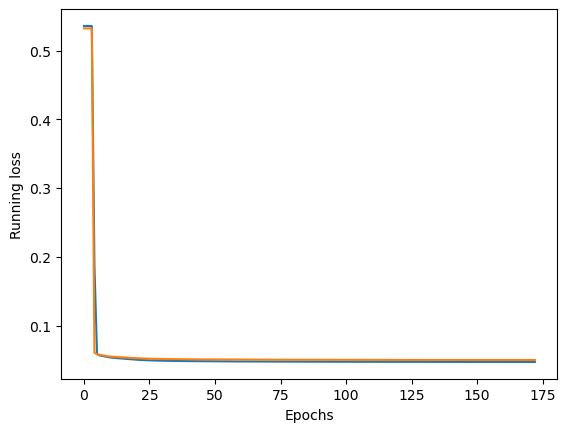

In [35]:
plt.plot(avg_train_loss_list)
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Running loss")
plt.show()

In [22]:
with open('loss_golden_std_retrain03.txt', 'w') as f:
    f.write('train_loss_per_epoch_list: ' + str(train_loss_list) + '\n')
    f.write('\n')
    f.write('avg_train_loss_list: ' + str(avg_train_loss_list) + '\n')
    f.write('\n')
    f.write('val_loss_list: ' + str(val_loss_list) + '\n')

In [23]:
# torch.save(final_model_trainset, 'model_100206_golden_std_retrain_trainset.pt')
torch.save(final_model_valset, 'model_100206_golden_std_retrain03.pt')